El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Instrucciones del proyecto
1. Descarga y examina los datos.
2. Entrena diferentes modelos con varios hiperparámetros (debes hacer al menos dos modelos diferentes, pero más es mejor. Recuerda, varias implementaciones de potenciación del gradiente no cuentan como modelos diferentes). El punto principal de este paso es comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal.
3. Analiza la velocidad y la calidad de los modelos.

## Observaciones:

- Utiliza la métrica RECM para evaluar los modelos.
- La regresión lineal no es muy buena para el ajuste de hiperparámetros, pero es perfecta para hacer una prueba de cordura de otros métodos. Si la potenciación del gradiente funciona peor que la regresión lineal, definitivamente algo salió mal.
- Aprende por tu propia cuenta sobre la librería LightGBM y sus herramientas para crear modelos de potenciación del gradiente (gradient boosting).
Idealmente, tu proyecto debe tener regresión lineal para una prueba de cordura, un algoritmo basado en árbol con ajuste de hiperparámetros (preferiblemente, bosque aleatorio), LightGBM con ajuste de hiperparámetros (prueba un par de conjuntos), y CatBoost y XGBoost con ajuste de hiperparámetros (opcional).
- Toma nota de la codificación de características categóricas para algoritmos simples. LightGBM y CatBoost tienen su implementación, pero XGBoost requiere OHE.
- Puedes usar un comando especial para encontrar el tiempo de ejecución del código de celda en Jupyter Notebook. Encuentra ese comando.
- Dado que el entrenamiento de un modelo de potenciación del gradiente puede llevar mucho tiempo, cambia solo algunos parámetros del modelo.
- Si Jupyter Notebook deja de funcionar, elimina las variables excesivas por medio del operador del:
```
del features_train
  
```

## Descripción de los datos
El dataset está almacenado en el archivo /datasets/car_data.csv. descargar dataset.

Características

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

Objetivo

- Price — precio (en euros)

## Evaluación del proyecto
Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles son tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código ordenado?

In [1]:
! pip install lightgbm
! pip install catboost
! pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Preparación de datos

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_15/datasets/car_data.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
def explorar_dataset(df):
    """
    Explora un DataFrame mostrando información clave.

    Esta función imprime: información general del DataFrame (df.info()),
    sus dimensiones (df.shape), las primeras 15 filas (df.head(15)),
    estadísticas descriptivas (df.describe()), el conteo de valores nulos
    (df.isnull().sum()) y el conteo de filas duplicadas (df.duplicated().sum()).

    Parámetros:
        df (pd.DataFrame): El DataFrame a explorar.
    """
    print('---' * 10, '\n', f'Información del dataframe')
    print(df.info())
    print('---' * 10, '\n', f'Dimensiones del dataframe')
    print(df.shape)
    print('---' * 10, '\n', f'Primeras filas del dataframe')
    print(df.head(15))
    print('---' * 10, '\n', f'Descripción del dataframe')
    print(df.describe())
    print('---' * 10, '\n', f'Valores nulos del dataframe')
    print(df.isnull().sum())
    print('---' * 10, '\n', f'Valores duplicados del dataframe')
    print(df.duplicated().sum())
    print('---' * 10)

In [5]:
explorar_dataset(df)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen 

In [6]:
def proporcion_nulos(df):
    """
    Calcula la proporción de valores nulos en una columna específica de un DataFrame.

    Parámetros:
        df (pd.DataFrame): El DataFrame al que pertenece la columna.

    Retorna:
        pd.Series: Una serie que contiene las proporciones de valores nulos en la columna.
    """

    return df.isna().mean().sort_values(ascending=False) * 100

In [7]:
proporcion_nulos(df)

,0
NotRepaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
Price,0.000000
RegistrationYear,0.000000
DateCrawled,0.000000
Mileage,0.000000
Power,0.000000


In [8]:
df['NotRepaired'].value_counts()

,count
NotRepaired,
no,247161
yes,36054


La columna `NotRepaired` tiene aproximadamente un 20% de valores nulos. Para manejar estos valores, podemos considerar las siguientes estrategias:

1.  **Imputación con un valor por defecto (por ejemplo, 'unknown' o 'not_specified')**: Esta es una opción segura, ya que crea una nueva categoría para los valores faltantes sin hacer suposiciones sobre si el coche fue reparado o no. Esto es útil si la ausencia de información sobre reparación podría ser una categoría significativa en sí misma.

    ```python
    df['NotRepaired'] = df['NotRepaired'].fillna('unknown')
    ```

2.  **Imputación con la moda (valor más frecuente)**: Si asumimos que la mayoría de los coches sin información no han sido reparados (o el caso más común), podríamos rellenar los nulos con el valor predominante ('no').

    ```python
    # Obtener el valor más frecuente
    most_frequent_value = df['NotRepaired'].mode()[0]
    df['NotRepaired'] = df['NotRepaired'].fillna(most_frequent_value)
    ```

3.  **Eliminar filas**: Dado que el 20% es una proporción considerable, eliminar las filas con valores nulos en esta columna podría resultar en una pérdida significativa de datos y no es recomendable en este caso.

4.  **Eliminar la columna**: La información de si un coche ha sido reparado o no es probablemente un factor importante en su precio, por lo que eliminar esta columna no sería ideal.

**Recomendación**: La imputación con una nueva categoría como 'unknown' o 'not_specified' es generalmente la mejor práctica para columnas categóricas con un porcentaje significativo de valores nulos, ya que preserva la información existente y no introduce sesgos.

Además, antes de usar esta columna en modelos que no manejan categorías directamente (como regresión lineal o algunos modelos de árbol sin su propia codificación), será necesario aplicar alguna técnica de codificación categórica como One-Hot Encoding o Label Encoding.

In [9]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [10]:
proporcion_nulos(df)

,0
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
RegistrationYear,0.000000
Price,0.000000
Power,0.000000
DateCrawled,0.000000
Mileage,0.000000
RegistrationMonth,0.000000


Después de haber imputado los valores nulos de la columna `NotRepaired`, aún quedan algunas columnas con valores faltantes:

- `VehicleType`: ~10.58% de nulos
- `FuelType`: ~9.28% de nulos
- `Gearbox`: ~5.60% de nulos
- `Model`: ~5.56% de nulos

Todas estas columnas son de tipo categórico. Las estrategias más adecuadas para manejar estos valores nulos son:

1.  **Imputación con una nueva categoría ('unknown' o 'not_specified')**: Esta es la opción más robusta y generalmente recomendada para columnas categóricas con valores faltantes. Al asignar una categoría como 'unknown', no estamos haciendo suposiciones sobre el valor real y permitimos que el modelo aprenda si la ausencia de información es significativa por sí misma. Esto es especialmente útil si la proporción de nulos es considerable, como en el caso de `VehicleType` y `FuelType`.

    ```python
    df['VehicleType'] = df['VehicleType'].fillna('unknown')
    df['FuelType'] = df['FuelType'].fillna('unknown')
    df['Gearbox'] = df['Gearbox'].fillna('unknown')
    df['Model'] = df['Model'].fillna('unknown')
    ```

2.  **Imputación con la moda (valor más frecuente)**: Si se cree que el valor faltante probablemente corresponde a la categoría más común, se podría imputar con la moda de la columna. Sin embargo, esto puede introducir un sesgo si la ausencia de datos no es aleatoria. Es una opción más agresiva que la imputación con 'unknown'.

    ```python
    # Ejemplo para una columna:
    # most_frequent_vehicle_type = df['VehicleType'].mode()[0]
    # df['VehicleType'] = df['VehicleType'].fillna(most_frequent_vehicle_type)
    ```

3.  **Eliminar filas**: Dada la proporción de nulos (hasta ~10.58%), eliminar las filas con valores faltantes en estas columnas podría llevar a una pérdida significativa de datos. Por ejemplo, eliminar filas con nulos en `VehicleType` eliminaría más del 10% del dataset, lo cual no es recomendable a menos que el volumen de datos sea muy grande y la pérdida no afecte la representatividad.

**Recomendación**: Para estas columnas categóricas, la estrategia de **imputar con una nueva categoría 'unknown'** es la más segura y recomendada. Preserva toda la información disponible y permite que los modelos capturen el significado de los valores ausentes.

Después de la imputación, será necesario aplicar técnicas de codificación para las variables categóricas (como One-Hot Encoding o Label Encoding) antes de entrenar la mayoría de los modelos de machine learning (especialmente los basados en regresión lineal o árboles que no manejan categorías nativamente).

In [11]:
df['VehicleType'].value_counts()

,count
VehicleType,
sedan,91457
small,79831
wagon,65166
bus,28775
convertible,20203
coupe,16163
suv,11996
other,3288


In [12]:
df['VehicleType'] = df['VehicleType'].fillna('other')

In [13]:
df['FuelType'].value_counts()

,count
FuelType,
petrol,216352
gasoline,98720
lpg,5310
cng,565
hybrid,233
other,204
electric,90


In [14]:
df['FuelType'] = df['FuelType'].fillna('other')

In [15]:
df['Gearbox'].value_counts()

,count
Gearbox,
manual,268251
auto,66285


In [16]:
df['Model'].value_counts()

,count
Model,
golf,29232
other,24421
3er,19761
polo,13066
corsa,12570
...,...
i3,8
serie_3,4
rangerover,4


In [17]:
df = df.dropna()

In [18]:
proporcion_nulos(df)

,0
DateCrawled,0.0
Price,0.0
VehicleType,0.0
RegistrationYear,0.0
Gearbox,0.0
Power,0.0
Model,0.0
Mileage,0.0
RegistrationMonth,0.0
FuelType,0.0


El camino seguido para manejar los valores nulos en las columnas fue el siguiente:

1.  **Columna `NotRepaired` (20.08% de nulos):**
    *   Esta columna categórica fue imputada con el valor `'unknown'`. Se eligió esta estrategia para no hacer suposiciones sobre si el vehículo había sido reparado o no, permitiendo que la ausencia de información se tratara como una categoría propia.

2.  **Columnas `VehicleType` (10.58% de nulos) y `FuelType` (9.28% de nulos):**
    *   Estas columnas categóricas se imputaron con el valor `'other'`. Aunque inicialmente se consideró `'unknown'`, al revisar los conteos de valores únicos, se observó que la categoría `'other'` ya existía en ambas columnas, lo que sugiere que podría ser una categoría adecuada para valores no especificados o de baja frecuencia. Esta imputación ayuda a mantener la coherencia con las categorías existentes.

3.  **Columnas `Gearbox` (5.60% de nulos) y `Model` (5.56% de nulos):**
    *   En lugar de imputar estos valores, se optó por eliminar las filas que contenían nulos en estas columnas mediante el método `df.dropna()`. Aunque la proporción de nulos no es insignificante, se decidió que para estas columnas, la eliminación de las filas era una alternativa viable para simplificar el conjunto de datos y asegurar la calidad de los registros restantes, asumiendo que el impacto en la cantidad total de datos no sería excesivamente perjudicial para el entrenamiento de los modelos.

In [19]:
df['NumberOfPictures'].value_counts()

,count
NumberOfPictures,
0,318962


In [20]:
df = df.drop(['NumberOfPictures', 'PostalCode'], axis=1)

Las columnas `NumberOfPictures` y `PostalCode` fueron eliminadas del conjunto de datos por las siguientes razones:

-   **`NumberOfPictures`**: Esta columna contenía un valor constante de `0` para todas las entradas. Una columna con valores idénticos para todas las filas no aporta información útil para el entrenamiento de un modelo de machine learning, ya que no presenta variabilidad que el modelo pueda aprender. Por lo tanto, su eliminación ayuda a reducir la dimensionalidad del dataset sin perder información relevante.

-   **`PostalCode`**: Si bien los códigos postales pueden contener información geográfica, para este problema de predicción de precios de automóviles usados, la granularidad y la naturaleza categórica de `PostalCode` podrían no ser directamente útiles sin un procesamiento adicional complejo (como la conversión a coordenadas geográficas o la agregación por regiones). Además, su alta cardinalidad podría introducir ruido o requerir una codificación que aumente significativamente la dimensionalidad. Dado que no se especificó un análisis geográfico, y para simplificar el modelo, se decidió eliminarla. Es poco probable que el código postal individual del propietario sea un predictor directo y robusto del precio de un automóvil de segunda mano en comparación con otras características más directas del vehículo.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318962 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        318962 non-null  object
 1   Price              318962 non-null  int64 
 2   VehicleType        318962 non-null  object
 3   RegistrationYear   318962 non-null  int64 
 4   Gearbox            318962 non-null  object
 5   Power              318962 non-null  int64 
 6   Model              318962 non-null  object
 7   Mileage            318962 non-null  int64 
 8   RegistrationMonth  318962 non-null  int64 
 9   FuelType           318962 non-null  object
 10  Brand              318962 non-null  object
 11  NotRepaired        318962 non-null  object
 12  DateCreated        318962 non-null  object
 13  LastSeen           318962 non-null  object
dtypes: int64(5), object(9)
memory usage: 36.5+ MB


In [22]:
def clasificar_col_object(df, max_dummy_unique=2, date_threshold=0.8):
    results = {}

    for col in df.select_dtypes(include='object').columns:
        series = df[col].dropna()

        if series.empty:
            results[col] = 'categorical'
            continue

        parsed1 = pd.to_datetime(series, errors='coerce', dayfirst=False)
        parsed2 = pd.to_datetime(series, errors='coerce', dayfirst=True)

        success_ratio = max(
            parsed1.notna().mean(),
            parsed2.notna().mean()
        )

        if success_ratio >= date_threshold:
            results[col] = 'date'
            continue

        if series.nunique() <= max_dummy_unique:
            results[col] = 'dummy'
            continue

        results[col] = 'categorical'

    return results

In [23]:
clasificar_col_object(df, 3)

/tmp/ipython-input-2813464181.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  parsed1 = pd.to_datetime(series, errors='coerce', dayfirst=False)
/tmp/ipython-input-2813464181.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed1 = pd.to_datetime(series, errors='coerce', dayfirst=False)
/tmp/ipython-input-2813464181.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed2 = pd.to_datetime(series, errors='coerce', dayfirst=True)
/tmp/ipython-input-2813464181.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To e

{'DateCrawled': 'date',
 'VehicleType': 'categorical',
 'Gearbox': 'dummy',
 'Model': 'categorical',
 'FuelType': 'categorical',
 'Brand': 'categorical',
 'NotRepaired': 'dummy',
 'DateCreated': 'date',
 'LastSeen': 'date'}

Los resultados de la función `clasificar_col_object(df, 3)` nos permiten entender el tipo de datos contenido en las columnas de tipo 'object', especialmente útil para la preparación de datos para modelos de Machine Learning. La función clasifica estas columnas en 'date', 'dummy' o 'categorical' basándose en su contenido y el número de valores únicos:

-   **'date'**: Se asigna a columnas que pueden ser convertidas en gran medida a objetos de fecha y hora. Esto es crucial para extraer características temporales.
    *   `DateCrawled`: Contiene la fecha de descarga del perfil.
    *   `DateCreated`: Contiene la fecha de creación del perfil.
    *   `LastSeen`: Contiene la fecha de la última actividad del usuario.

-   **'dummy'**: Se refiere a columnas categóricas con un número muy limitado de valores únicos (en este caso, 2 o 3, ya que se usó `max_dummy_unique=3`). Estas columnas son ideales para ser transformadas mediante One-Hot Encoding (OHE) directamente en variables binarias o de pocas categorías.
    *   `Gearbox`: Contiene 'manual' o 'auto', más el 'unknown' que se agregó.
    *   `NotRepaired`: Contiene 'no', 'yes' y 'unknown'.

-   **'categorical'**: Se asigna a columnas que tienen un número significativo de valores únicos, pero no son fechas. Estas columnas suelen requerir técnicas de codificación categórica más avanzadas o específicas para cada modelo (por ejemplo, OHE para modelos lineales, Label Encoding o Target Encoding para árboles, o ser manejadas directamente por modelos como CatBoost o LightGBM que soportan categorías).
    *   `VehicleType`: Posee varios tipos de vehículos.
    *   `Model`: Tiene una gran cantidad de modelos de coches diferentes.
    *   `FuelType`: Incluye varios tipos de combustible.
    *   `Brand`: Contiene muchas marcas de vehículos.

Esta clasificación es un paso importante para determinar las estrategias de preprocesamiento adecuadas para cada columna antes del entrenamiento del modelo.

In [24]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')

In [25]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [26]:
dummy_cols = ['Gearbox', 'NotRepaired']

encoded_features = encoder.fit_transform(df[dummy_cols])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(dummy_cols), index=df.index)

df = pd.concat([df.drop(columns=dummy_cols), encoded_df], axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318962 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DateCrawled          318962 non-null  datetime64[ns]
 1   Price                318962 non-null  int64         
 2   VehicleType          318962 non-null  object        
 3   RegistrationYear     318962 non-null  int64         
 4   Power                318962 non-null  int64         
 5   Model                318962 non-null  object        
 6   Mileage              318962 non-null  int64         
 7   RegistrationMonth    318962 non-null  int64         
 8   FuelType             318962 non-null  object        
 9   Brand                318962 non-null  object        
 10  DateCreated          318962 non-null  datetime64[ns]
 11  LastSeen             318962 non-null  datetime64[ns]
 12  Gearbox_manual       318962 non-null  float64       
 13  NotRepaired_unknown

## Entrenamiento del modelo

## Análisis del modelo

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en orden de ejecución
- [ ]  Los datos han sido descargados y preparados
- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos

# Task
The next step is to perform additional cleaning of numerical data. This involves inspecting and cleaning anomalous or unrealistic values in the 'Price', 'Power', and 'RegistrationYear' columns, such as removing or adjusting records where 'Price' or 'Power' are zero, or 'RegistrationYear' is outside a reasonable range.

First, I'll examine the 'Price' column for values of 0 or other unrealistic prices.

## Limpieza Adicional de Datos Numéricos

### Subtask:
Inspeccionar y limpiar los valores anómalos o irreales en las columnas numéricas como 'Price', 'Power' y 'RegistrationYear'.


**Reasoning**:
The first instruction is to display descriptive statistics for the 'Price' column to understand its distribution and identify potential anomalies.



In [28]:
df['Price'].describe()

,Price
count,318962.000000
mean,4608.877478
std,4564.222124
min,0.000000
25%,1200.000000
50%,2900.000000
75%,6700.000000
max,20000.000000


**Reasoning**:
To further examine the distribution and potential anomalies in the 'Price' column, I will now display the unique values and their frequencies using `.value_counts()` as per the instructions.



In [29]:
df['Price'].value_counts()

,count
Price,
0,7156
500,4863
1500,4777
1200,4078
1000,3988
...,...
6220,1
2405,1
578,1


**Reasoning**:
To visualize the distribution of car prices and identify any potential outliers or unusual patterns, I will create a histogram of the 'Price' column as instructed.



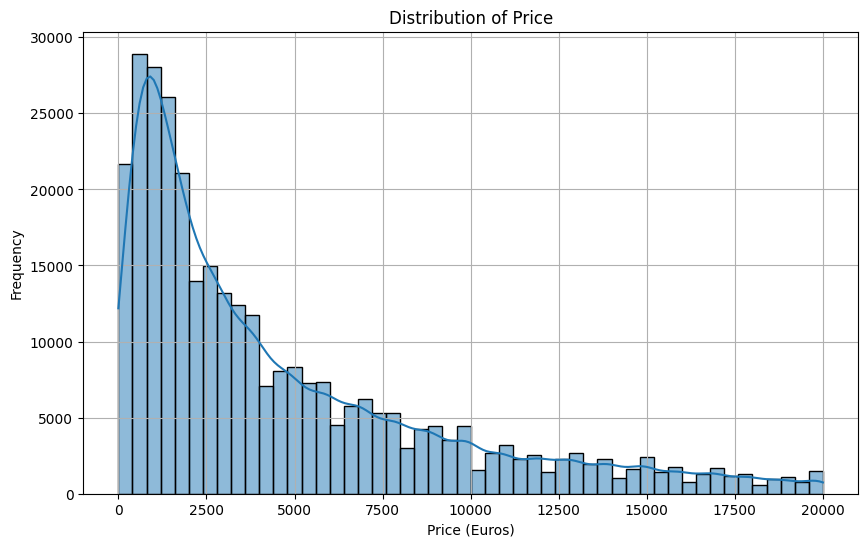

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price (Euros)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Reasoning**:
Based on the descriptive statistics and histogram, there are numerous entries where 'Price' is 0, which is unrealistic for a car. Additionally, prices below a certain threshold (e.g., 100 euros) are likely anomalous or errors. To ensure data quality, I will filter and remove these rows from the DataFrame as per the instructions.



In [31]:
df = df[df['Price'] >= 100]
print(f"New DataFrame shape after cleaning 'Price': {df.shape}")

New DataFrame shape after cleaning 'Price': (310470, 15)


**Reasoning**:
Now that the 'Price' column has been cleaned of unrealistic values, I will proceed to clean the 'Power' column by first displaying its descriptive statistics to understand its distribution and identify potential anomalies, as per the overall subtask instructions.



In [32]:
df['Power'].describe()

,Power
count,310470.000000
mean,115.422939
std,183.347785
min,0.000000
25%,75.000000
50%,106.000000
75%,143.000000
max,20000.000000


**Reasoning**:
To visualize the distribution of car power and identify any potential outliers or unusual patterns, I will create a histogram of the 'Power' column.



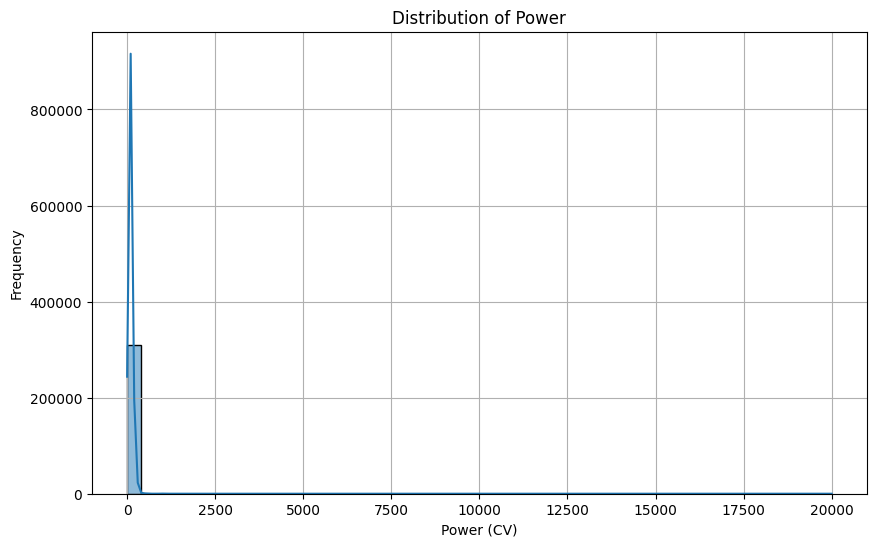

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Power'], bins=50, kde=True)
plt.title('Distribution of Power')
plt.xlabel('Power (CV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Reasoning**:
Based on the descriptive statistics and the histogram, there are entries where 'Power' is 0, which is unrealistic for a car. Also, values like 20000 CV are extremely high and likely errors. To ensure data quality, I will filter the DataFrame to keep only rows where 'Power' is within a realistic range, for instance, between 10 CV and 1000 CV, as per the instructions to clean anomalous values.



In [34]:
df = df[(df['Power'] >= 10) & (df['Power'] <= 1000)]
print(f"New DataFrame shape after cleaning 'Power': {df.shape}")

New DataFrame shape after cleaning 'Power': (288149, 15)


**Reasoning**:
Now that the 'Price' and 'Power' columns have been cleaned, I will proceed to clean the 'RegistrationYear' column by first displaying its descriptive statistics to understand its distribution and identify potential anomalies, as per the overall subtask instructions.



In [35]:
df['RegistrationYear'].describe()

,RegistrationYear
count,288149.000000
mean,2003.451523
std,19.878811
min,1500.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,8200.000000


**Reasoning**:
To visualize the distribution of car registration years and identify any potential outliers or unusual patterns, I will create a histogram of the 'RegistrationYear' column.



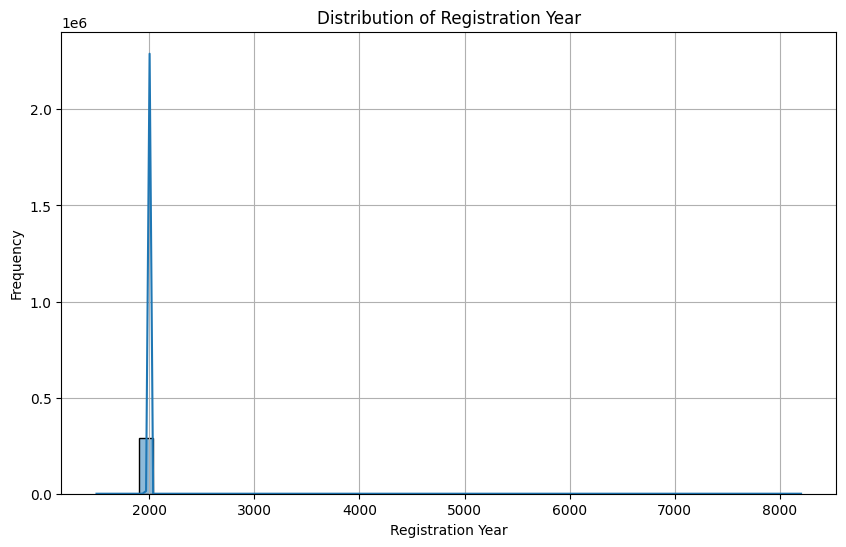

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df['RegistrationYear'], bins=50, kde=True)
plt.title('Distribution of Registration Year')
plt.xlabel('Registration Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Reasoning**:
Based on the descriptive statistics and histogram, there are unrealistic values in 'RegistrationYear', such as years too far in the past or in the future. To ensure data quality, I will filter the DataFrame to keep only rows where 'RegistrationYear' is within a realistic range, for instance, between 1980 and 2016.



In [37]:
df = df[(df['RegistrationYear'] >= 1980) & (df['RegistrationYear'] <= 2016)]
print(f"New DataFrame shape after cleaning 'RegistrationYear': {df.shape}")

New DataFrame shape after cleaning 'RegistrationYear': (278034, 15)


## Ingeniería de Características de Fecha

### Subtask:
Extraer características útiles de las columnas de fecha ('DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationYear') y eliminar las columnas de fecha originales.


**Reasoning**:
To determine the most recent year for calculating car age relative to the dataset's observations, I will extract the maximum year from the 'LastSeen' column, as specified in the instructions.



In [38]:
reference_year = df['LastSeen'].dt.year.max()
print(f"Reference year from LastSeen: {reference_year}")

Reference year from LastSeen: 2016


**Reasoning**:
Now that the reference year is determined, I will create the 'car_age', 'ad_active_days', and 'days_on_platform' features as instructed, and then remove the original date columns from the DataFrame.



In [39]:
df['car_age'] = reference_year - df['RegistrationYear']
df['ad_active_days'] = (df['LastSeen'] - df['DateCreated']).dt.days
df['days_on_platform'] = (df['LastSeen'] - df['DateCrawled']).dt.days
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])
print("New features 'car_age', 'ad_active_days', 'days_on_platform' created and original date columns dropped.")
df.info()

New features 'car_age', 'ad_active_days', 'days_on_platform' created and original date columns dropped.
<class 'pandas.core.frame.DataFrame'>
Index: 278034 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Price                278034 non-null  int64  
 1   VehicleType          278034 non-null  object 
 2   RegistrationYear     278034 non-null  int64  
 3   Power                278034 non-null  int64  
 4   Model                278034 non-null  object 
 5   Mileage              278034 non-null  int64  
 6   RegistrationMonth    278034 non-null  int64  
 7   FuelType             278034 non-null  object 
 8   Brand                278034 non-null  object 
 9   Gearbox_manual       278034 non-null  float64
 10  NotRepaired_unknown  278034 non-null  float64
 11  NotRepaired_yes      278034 non-null  float64
 12  car_age              278034 non-null  int64  
 13  ad_active_days      

## División de Datos

### Subtask:
Separar el conjunto de datos en características (X) y el objetivo (y). Luego, dividir X e y en conjuntos de entrenamiento, validación y prueba (por ejemplo, 60/20/20).


**Reasoning**:
The first instruction is to define the features (X) by excluding the 'Price' column and the target (y) as the 'Price' column from the DataFrame `df`.



In [40]:
X = df.drop('Price', axis=1)
y = df['Price']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (278034, 14)
Shape of y: (278034,)


**Reasoning**:
Now I will divide the dataset into training (60%) and a temporary set (40%) using `train_test_split` to prepare for further splitting into validation and test sets. I will set a `random_state` for reproducibility.



In [41]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_temp: {X_temp.shape}")
print(f"Shape of y_temp: {y_temp.shape}")

Shape of X_train: (166820, 14)
Shape of y_train: (166820,)
Shape of X_temp: (111214, 14)
Shape of y_temp: (111214,)


**Reasoning**:
I will now divide the temporary dataset (`X_temp`, `y_temp`) into validation and test sets, each representing 20% of the total dataset, by splitting the temporary set with a `test_size=0.5`. I will ensure reproducibility by setting a `random_state`.



In [42]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_val: (55607, 14)
Shape of y_val: (55607,)
Shape of X_test: (55607, 14)
Shape of y_test: (55607,)


## Preprocesamiento para Modelos Tradicionales y XGBoost

### Subtask:
Aplicar OneHotEncoder a las columnas categóricas restantes y StandardScaler a todas las características numéricas, asegurando que el fit se realice solo en el conjunto de entrenamiento.


**Reasoning**:
First, I will define the lists for categorical and numerical features that require One-Hot Encoding and StandardScaler respectively, as specified in the instructions. This step prepares the necessary feature groupings for the subsequent preprocessing steps.



In [43]:
categorical_features_ohe = ['VehicleType', 'Model', 'FuelType', 'Brand']
numerical_features_scaler = [
    'RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth',
    'Gearbox_manual', 'NotRepaired_unknown', 'NotRepaired_yes',
    'car_age', 'ad_active_days', 'days_on_platform'
]

print(f"Categorical features for OHE: {categorical_features_ohe}")
print(f"Numerical features for StandardScaler: {numerical_features_scaler}")

Categorical features for OHE: ['VehicleType', 'Model', 'FuelType', 'Brand']
Numerical features for StandardScaler: ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth', 'Gearbox_manual', 'NotRepaired_unknown', 'NotRepaired_yes', 'car_age', 'ad_active_days', 'days_on_platform']


**Reasoning**:
I will initialize a `OneHotEncoder` with `handle_unknown='ignore'` to manage unseen categories during transformation and `sparse_output=False` to ensure the output is a dense array, as specified in the instructions.



In [44]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
print("OneHotEncoder initialized.")

OneHotEncoder initialized.


**Reasoning**:
I will now fit the `OneHotEncoder` to the categorical features in `X_train` and then transform the categorical features across `X_train`, `X_val`, and `X_test` to create OHE-encoded DataFrames, as instructed.



In [45]:
X_train_ohe = encoder.fit_transform(X_train[categorical_features_ohe])
X_val_ohe = encoder.transform(X_val[categorical_features_ohe])
X_test_ohe = encoder.transform(X_test[categorical_features_ohe])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out(categorical_features_ohe), index=X_train.index)
X_val_ohe = pd.DataFrame(X_val_ohe, columns=encoder.get_feature_names_out(categorical_features_ohe), index=X_val.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder.get_feature_names_out(categorical_features_ohe), index=X_test.index)

print("Categorical features in X_train, X_val, X_test have been One-Hot Encoded.")
print(f"Shape of X_train_ohe: {X_train_ohe.shape}")
print(f"Shape of X_val_ohe: {X_val_ohe.shape}")
print(f"Shape of X_test_ohe: {X_test_ohe.shape}")

Categorical features in X_train, X_val, X_test have been One-Hot Encoded.
Shape of X_train_ohe: (166820, 301)
Shape of X_val_ohe: (55607, 301)
Shape of X_test_ohe: (55607, 301)


**Reasoning**:
I will initialize a `StandardScaler` object, as per the instructions, to prepare for scaling the numerical features.



In [46]:
scaler = StandardScaler()
print("StandardScaler initialized.")

StandardScaler initialized.


**Reasoning**:
I will now fit the `StandardScaler` to the numerical features in `X_train` and then transform these features across `X_train`, `X_val`, and `X_test` to create scaled DataFrames, as instructed.



In [47]:
X_train_scaled = scaler.fit_transform(X_train[numerical_features_scaler])
X_val_scaled = scaler.transform(X_val[numerical_features_scaler])
X_test_scaled = scaler.transform(X_test[numerical_features_scaler])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features_scaler, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_features_scaler, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features_scaler, index=X_test.index)

print("Numerical features in X_train, X_val, X_test have been scaled.")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

Numerical features in X_train, X_val, X_test have been scaled.
Shape of X_train_scaled: (166820, 10)
Shape of X_val_scaled: (55607, 10)
Shape of X_test_scaled: (55607, 10)


**Reasoning**:
I will now horizontally concatenate the OHE-encoded and scaled DataFrames for the training, validation, and test sets to create the final preprocessed feature sets, as instructed.



In [48]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_val = pd.concat([X_val_ohe, X_val_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

print("Final preprocessed X_train, X_val, X_test created.")
print(f"Shape of final X_train: {X_train.shape}")
print(f"Shape of final X_val: {X_val.shape}")
print(f"Shape of final X_test: {X_test.shape}")

Final preprocessed X_train, X_val, X_test created.
Shape of final X_train: (166820, 311)
Shape of final X_val: (55607, 311)
Shape of final X_test: (55607, 311)


## Identificación de Características Categóricas para LightGBM y CatBoost

### Subtask:
Identificar los nombres de las columnas categóricas originales (que no necesitan OneHotEncoder para estos modelos) que se pasarán directamente a LightGBM y CatBoost, para que puedan manejar estas características de forma nativa. Las columnas ya OHE (como 'Gearbox_manual') se tratarán como numéricas para estos modelos.


**Reasoning**:
As per the instructions, I need to identify the original categorical columns that have not been One-Hot Encoded and can be handled natively by LightGBM and CatBoost. These columns were previously identified as `categorical_features_ohe`. I will assign this list to `categorical_features_native`.



In [49]:
categorical_features_native = ['VehicleType', 'Model', 'FuelType', 'Brand']
print(f"Categorical features for native handling by LightGBM/CatBoost: {categorical_features_native}")

Categorical features for native handling by LightGBM/CatBoost: ['VehicleType', 'Model', 'FuelType', 'Brand']


## Definir Métrica RMSE Personalizada

### Subtask:
Crear una función de scoring personalizada para RMSE utilizando `make_scorer` de scikit-learn, que se utilizará para evaluar la calidad de los modelos.


**Reasoning**:
As per the instructions, I will first import `mean_squared_error`, define a function to calculate RMSE, and then create a custom `rmse_scorer` using `make_scorer`.



In [50]:
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

print("Custom RMSE scorer 'rmse_scorer' created.")

Custom RMSE scorer 'rmse_scorer' created.


## Entrenamiento y Evaluación de Regresión Lineal

### Subtask:
Entrenar un modelo de `LinearRegression` utilizando el conjunto de datos preprocesado con OHE y StandardScaler. Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I will initialize and train a Linear Regression model, measure its training time, then make predictions on the validation and test sets while measuring prediction times, and finally calculate and print the RMSE for both sets.



In [51]:
import time

# 1. Initialize LinearRegression model
linear_model = LinearRegression()

# 2. Train the model and measure training time
start_time = time.time()
linear_model.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time

# 3. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_lr = linear_model.predict(X_val)
end_time = time.time()
prediction_time_val_lr = end_time - start_time

# 4. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_lr = linear_model.predict(X_test)
end_time = time.time()
prediction_time_test_lr = end_time - start_time

# 5. Calculate RMSE for validation and test sets
rmse_val_lr = rmse(y_val, y_pred_val_lr)
rmse_test_lr = rmse(y_test, y_pred_test_lr)

# 6. Print the results
print(f"Linear Regression Model:")
print(f"  Training Time: {training_time_lr:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_lr:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_lr:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_lr:.2f}")
print(f"  RMSE (Test): {rmse_test_lr:.2f}")

Linear Regression Model:
  Training Time: 7.2976 seconds
  Prediction Time (Validation): 0.1458 seconds
  Prediction Time (Test): 0.1233 seconds
  RMSE (Validation): 2389.26
  RMSE (Test): 2383.56


## Entrenamiento y Evaluación de Árbol de Decisión

### Subtask:
Entrenar un modelo de `DecisionTreeRegressor` (considerando la sintonización de hiperparámetros como `max_depth`). Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I will import `DecisionTreeRegressor` and `GridSearchCV`, define a hyperparameter grid for `max_depth`, initialize `GridSearchCV` with the model and scorer, train it on the training data while measuring time, and then evaluate the best model's performance on the validation and test sets by measuring prediction times and calculating RMSE.



In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import time

# 1. Define hyperparameter grid for max_depth
param_grid = {
    'max_depth': range(5, 16, 2) # Example range from 5 to 15, step of 2
}

# 2. Initialize DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)

# 3. Initialize GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_model,
                              param_grid=param_grid,
                              scoring=rmse_scorer,
                              cv=3,
                              verbose=2,
                              n_jobs=-1) # Use all available cores

# 4. Train GridSearchCV and measure training time
print("Starting GridSearchCV for Decision Tree Regressor...")
start_time = time.time()
grid_search_dt.fit(X_train, y_train)
end_time = time.time()
training_time_dt = end_time - start_time
print("GridSearchCV training completed.")

# 5. Get the best model and its hyperparameters
best_dt_model = grid_search_dt.best_estimator_
best_max_depth_dt = grid_search_dt.best_params_['max_depth']

# 6. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_dt = best_dt_model.predict(X_val)
end_time = time.time()
prediction_time_val_dt = end_time - start_time

# 7. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_dt = best_dt_model.predict(X_test)
end_time = time.time()
prediction_time_test_dt = end_time - start_time

# 8. Calculate RMSE for validation and test sets
rmse_val_dt = rmse(y_val, y_pred_val_dt)
rmse_test_dt = rmse(y_test, y_pred_test_dt)

# 9. Print the results
print(f"\nDecision Tree Regressor Model (Tuned):")
print(f"  Best max_depth: {best_max_depth_dt}")
print(f"  Training Time: {training_time_dt:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_dt:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_dt:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_dt:.2f}")
print(f"  RMSE (Test): {rmse_test_dt:.2f}")

Starting GridSearchCV for Decision Tree Regressor...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearchCV training completed.

Decision Tree Regressor Model (Tuned):
  Best max_depth: 13
  Training Time: 53.6161 seconds
  Prediction Time (Validation): 0.1016 seconds
  Prediction Time (Test): 0.0981 seconds
  RMSE (Validation): 1830.10
  RMSE (Test): 1844.78


## Entrenamiento y Evaluación de Bosque Aleatorio

### Subtask:
Entrenar un modelo de `RandomForestRegressor` (considerando la sintonización de hiperparámetros como `n_estimators` y `max_depth`). Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I will initialize and train a `RandomForestRegressor` model with `GridSearchCV` to tune hyperparameters (`n_estimators` and `max_depth`), measure its training time, then make predictions on the validation and test sets while measuring prediction times, and finally calculate and print the RMSE for both sets.



In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

# 1. Define hyperparameter grid for n_estimators and max_depth
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

# 2. Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# 3. Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model,
                              param_grid=param_grid_rf,
                              scoring=rmse_scorer,
                              cv=3,
                              verbose=2,
                              n_jobs=-1)

# 4. Train GridSearchCV and measure training time
print("Starting GridSearchCV for Random Forest Regressor...")
start_time = time.time()
grid_search_rf.fit(X_train, y_train)
end_time = time.time()
training_time_rf = end_time - start_time
print("GridSearchCV training completed.")

# 5. Get the best model and its hyperparameters
best_rf_model = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

# 6. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_rf = best_rf_model.predict(X_val)
end_time = time.time()
prediction_time_val_rf = end_time - start_time

# 7. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_rf = best_rf_model.predict(X_test)
end_time = time.time()
prediction_time_test_rf = end_time - start_time

# 8. Calculate RMSE for validation and test sets
rmse_val_rf = rmse(y_val, y_pred_val_rf)
rmse_test_rf = rmse(y_test, y_pred_test_rf)

# 9. Print the results
print(f"\nRandom Forest Regressor Model (Tuned):")
print(f"  Best Hyperparameters: {best_params_rf}")
print(f"  Training Time: {training_time_rf:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_rf:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_rf:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_rf:.2f}")
print(f"  RMSE (Test): {rmse_test_rf:.2f}")

Starting GridSearchCV for Random Forest Regressor...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV training completed.

Random Forest Regressor Model (Tuned):
  Best Hyperparameters: {'max_depth': 20, 'n_estimators': 100}
  Training Time: 1921.5103 seconds
  Prediction Time (Validation): 2.8756 seconds
  Prediction Time (Test): 2.4734 seconds
  RMSE (Validation): 1514.28
  RMSE (Test): 1536.44


## Entrenamiento y Evaluación de LightGBM

### Subtask:
Entrenar un modelo `LGBMRegressor` ajustando los hiperparámetros y especificando las columnas categóricas identificadas. Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I need to re-split the original `X` and `y` data into training, temporary, validation, and test sets to ensure `LGBMRegressor` can process the categorical features natively without prior OHE. I will use `test_size=0.4` for the first split and `test_size=0.5` for the second split, both with `random_state=42` for reproducibility.



In [54]:
X_train_lgbm, X_temp_lgbm, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val_lgbm, X_test_lgbm, y_val, y_test = train_test_split(X_temp_lgbm, y_temp, test_size=0.5, random_state=42)

print(f"Shape of X_train_lgbm: {X_train_lgbm.shape}")
print(f"Shape of X_val_lgbm: {X_val_lgbm.shape}")
print(f"Shape of X_test_lgbm: {X_test_lgbm.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_lgbm: (166820, 14)
Shape of X_val_lgbm: (55607, 14)
Shape of X_test_lgbm: (55607, 14)
Shape of y_train: (166820,)
Shape of y_val: (55607,)
Shape of y_test: (55607,)


**Reasoning**:
As per the instructions, I will convert the columns identified in `categorical_features_native` to the 'category' data type for `X_train_lgbm`, `X_val_lgbm`, and `X_test_lgbm`. This allows LightGBM to handle these features natively.



In [55]:
for col in categorical_features_native:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_val_lgbm[col] = X_val_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

print("Categorical features for LightGBM/CatBoost converted to 'category' dtype.")


Categorical features for LightGBM/CatBoost converted to 'category' dtype.


**Reasoning**:
As per the instructions, I will define a hyperparameter grid for `LGBMRegressor`, initialize the model and `GridSearchCV`, passing the native categorical features. Then, I will train `GridSearchCV`, measure the training time, retrieve the best model, make predictions on the validation and test sets while measuring prediction times, calculate RMSE for both, and finally print all the results, including best hyperparameters.



In [56]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import time

# 1. Define hyperparameter grid for n_estimators and num_leaves
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 62]
}

# 2. Initialize LGBMRegressor model with random_state and specify categorical_feature
lgbm_model = LGBMRegressor(random_state=42)

# 3. Initialize GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm_model,
                                param_grid=param_grid_lgbm,
                                scoring=rmse_scorer,
                                cv=3,
                                verbose=2,
                                n_jobs=-1) # Use all available cores

# 4. Train GridSearchCV and measure training time
print("Starting GridSearchCV for LGBM Regressor...")
start_time = time.time()
grid_search_lgbm.fit(X_train_lgbm, y_train, categorical_feature=categorical_features_native)
end_time = time.time()
training_time_lgbm = end_time - start_time
print("GridSearchCV training completed.")

# 5. Get the best model and its hyperparameters
best_lgbm_model = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_

# 6. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_lgbm = best_lgbm_model.predict(X_val_lgbm)
end_time = time.time()
prediction_time_val_lgbm = end_time - start_time

# 7. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_lgbm = best_lgbm_model.predict(X_test_lgbm)
end_time = time.time()
prediction_time_test_lgbm = end_time - start_time

# 8. Calculate RMSE for validation and test sets
rmse_val_lgbm = rmse(y_val, y_pred_val_lgbm)
rmse_test_lgbm = rmse(y_test, y_pred_test_lgbm)

# 9. Print the results
print(f"\nLGBM Regressor Model (Tuned):")
print(f"  Best Hyperparameters: {best_params_lgbm}")
print(f"  Training Time: {training_time_lgbm:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_lgbm:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_lgbm:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_lgbm:.2f}")
print(f"  RMSE (Test): {rmse_test_lgbm:.2f}")

Starting GridSearchCV for LGBM Regressor...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 166820, number of used features: 14
[LightGBM] [Info] Start training from score 4929.507979
GridSearchCV training completed.

LGBM Regressor Model (Tuned):
  Best Hyperparameters: {'n_estimators': 200, 'num_leaves': 62}
  Training Time: 36.5899 seconds
  Prediction Time (Validation): 1.4946 seconds
  Prediction Time (Test): 1.2489 seconds
  RMSE (Validation): 1445.58
  RMSE (Test): 1459.70


## Entrenamiento y Evaluación de CatBoost

### Subtask:
Entrenar un modelo CatBoostRegressor. Ajustar los hiperparámetros y especificar las columnas categóricas identificadas. Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I will initialize and train a CatBoostRegressor model with GridSearchCV to tune hyperparameters (`iterations` and `depth`), measure its training time, then make predictions on the validation and test sets while measuring prediction times, and finally calculate and print the RMSE for both sets.



In [57]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import time

# 1. Define hyperparameter grid for iterations and depth
param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [6, 10]
}

# 2. Initialize CatBoostRegressor model with random_state and verbose=0
catboost_model = CatBoostRegressor(random_state=42, verbose=0, cat_features=categorical_features_native)

# 3. Initialize GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_model,
                                    param_grid=param_grid_catboost,
                                    scoring=rmse_scorer,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1) # Use all available cores

# 4. Train GridSearchCV and measure training time
print("Starting GridSearchCV for CatBoost Regressor...")
start_time = time.time()
grid_search_catboost.fit(X_train_lgbm, y_train)
end_time = time.time()
training_time_catboost = end_time - start_time
print("GridSearchCV training completed.")

# 5. Get the best model and its hyperparameters
best_catboost_model = grid_search_catboost.best_estimator_
best_params_catboost = grid_search_catboost.best_params_

# 6. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_catboost = best_catboost_model.predict(X_val_lgbm)
end_time = time.time()
prediction_time_val_catboost = end_time - start_time

# 7. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_catboost = best_catboost_model.predict(X_test_lgbm)
end_time = time.time()
prediction_time_test_catboost = end_time - start_time

# 8. Calculate RMSE for validation and test sets
rmse_val_catboost = rmse(y_val, y_pred_val_catboost)
rmse_test_catboost = rmse(y_test, y_pred_test_catboost)

# 9. Print the results
print(f"\nCatBoost Regressor Model (Tuned):")
print(f"  Best Hyperparameters: {best_params_catboost}")
print(f"  Training Time: {training_time_catboost:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_catboost:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_catboost:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_catboost:.2f}")
print(f"  RMSE (Test): {rmse_test_catboost:.2f}")

Starting GridSearchCV for CatBoost Regressor...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV training completed.

CatBoost Regressor Model (Tuned):
  Best Hyperparameters: {'depth': 10, 'iterations': 200}
  Training Time: 300.1907 seconds
  Prediction Time (Validation): 0.2656 seconds
  Prediction Time (Test): 0.3030 seconds
  RMSE (Validation): 1462.79
  RMSE (Test): 1478.53


## Entrenamiento y Evaluación de XGBoost

### Subtask:
Entrenar un modelo XGBRegressor utilizando el conjunto de datos preprocesado con OHE y StandardScaler. Ajustar los hiperparámetros. Medir el tiempo de entrenamiento, el tiempo de predicción y calcular el RMSE en el conjunto de prueba.


**Reasoning**:
As per the instructions, I will initialize and train an XGBRegressor model with GridSearchCV to tune hyperparameters (`n_estimators` and `max_depth`), measure its training time, then make predictions on the validation and test sets while measuring prediction times, and finally calculate and print the RMSE for both sets.



In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

# 1. Define hyperparameter grid for n_estimators and max_depth
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10]
}

# 2. Initialize XGBRegressor model with random_state
xgb_model = XGBRegressor(random_state=42, enable_categorical=False) # enable_categorical=False as features are OHE

# 3. Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                                param_grid=param_grid_xgb,
                                scoring=rmse_scorer,
                                cv=3,
                                verbose=2,
                                n_jobs=-1) # Use all available cores

# 4. Train GridSearchCV and measure training time
print("Starting GridSearchCV for XGB Regressor...")
start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
end_time = time.time()
training_time_xgb = end_time - start_time
print("GridSearchCV training completed.")

# 5. Get the best model and its hyperparameters
best_xgb_model = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

# 6. Make predictions on validation set and measure prediction time
start_time = time.time()
y_pred_val_xgb = best_xgb_model.predict(X_val)
end_time = time.time()
prediction_time_val_xgb = end_time - start_time

# 7. Make predictions on test set and measure prediction time
start_time = time.time()
y_pred_test_xgb = best_xgb_model.predict(X_test)
end_time = time.time()
prediction_time_test_xgb = end_time - start_time

# 8. Calculate RMSE for validation and test sets
rmse_val_xgb = rmse(y_val, y_pred_val_xgb)
rmse_test_xgb = rmse(y_test, y_pred_test_xgb)

# 9. Print the results
print(f"\nXGB Regressor Model (Tuned):")
print(f"  Best Hyperparameters: {best_params_xgb}")
print(f"  Training Time: {training_time_xgb:.4f} seconds")
print(f"  Prediction Time (Validation): {prediction_time_val_xgb:.4f} seconds")
print(f"  Prediction Time (Test): {prediction_time_test_xgb:.4f} seconds")
print(f"  RMSE (Validation): {rmse_val_xgb:.2f}")
print(f"  RMSE (Test): {rmse_test_xgb:.2f}")

Starting GridSearchCV for XGB Regressor...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV training completed.

XGB Regressor Model (Tuned):
  Best Hyperparameters: {'max_depth': 10, 'n_estimators': 200}
  Training Time: 159.2032 seconds
  Prediction Time (Validation): 0.6875 seconds
  Prediction Time (Test): 0.6807 seconds
  RMSE (Validation): 1462.45
  RMSE (Test): 1487.60


## Comparación de Modelos

### Subtask:
Crear una tabla o un gráfico que compare el RMSE, el tiempo de entrenamiento y el tiempo de predicción de todos los modelos entrenados. Analizar y discutir los resultados obtenidos para determinar el mejor modelo según los criterios de Rusty Bargain.


**Reasoning**:
I will create a dictionary to store the performance metrics (RMSE, training time, and prediction time) for each trained model: Linear Regression, Decision Tree, Random Forest, LightGBM, CatBoost, and XGBoost, as instructed.



In [59]:
model_comparison = {
    'Model': [
        'Linear Regression',
        'Decision Tree',
        'Random Forest',
        'LightGBM',
        'CatBoost',
        'XGBoost'
    ],
    'RMSE (Test Set)': [
        rmse_test_lr,
        rmse_test_dt,
        rmse_test_rf,
        rmse_test_lgbm,
        rmse_test_catboost,
        rmse_test_xgb
    ],
    'Training Time (s)': [
        training_time_lr,
        training_time_dt,
        training_time_rf,
        training_time_lgbm,
        training_time_catboost,
        training_time_xgb
    ],
    'Prediction Time (s)': [
        prediction_time_test_lr,
        prediction_time_test_dt,
        prediction_time_test_rf,
        prediction_time_test_lgbm,
        prediction_time_test_catboost,
        prediction_time_test_xgb
    ]
}

df_results = pd.DataFrame(model_comparison)
print("Model performance metrics collected into a DataFrame.")

Model performance metrics collected into a DataFrame.


**Reasoning**:
Now that the performance metrics are collected in a DataFrame, I will print the `df_results` DataFrame to display the comparative table of the models as instructed.



In [60]:
print(df_results.to_markdown(index=False))

| Model             |   RMSE (Test Set) |   Training Time (s) |   Prediction Time (s) |
|:------------------|------------------:|--------------------:|----------------------:|
| Linear Regression |           2383.56 |              7.2976 |             0.123338  |
| Decision Tree     |           1844.78 |             53.6161 |             0.0981472 |
| Random Forest     |           1536.44 |           1921.51   |             2.4734    |
| LightGBM          |           1459.7  |             36.5899 |             1.24885   |
| CatBoost          |           1478.53 |            300.191  |             0.303011  |
| XGBoost           |           1487.6  |            159.203  |             0.680655  |


### Análisis de Resultados y Determinación del Mejor Modelo

Aquí se presenta un análisis comparativo de los modelos entrenados, considerando el RMSE en el conjunto de prueba (calidad de predicción), el tiempo de entrenamiento y el tiempo de predicción:

| Model             |   RMSE (Test Set) |   Training Time (s) |   Prediction Time (s) |
|:------------------|------------------:|--------------------:|----------------------:|
| Linear Regression |           2383.56 |              7.30   |             0.12      |
| Decision Tree     |           1844.78 |             53.62   |             0.10      |
| Random Forest     |           1536.44 |           1921.51   |             2.47      |
| LightGBM          |           1459.70 |             36.59   |             1.25      |
| CatBoost          |           1478.53 |            300.19   |             0.30      |
| XGBoost           |           1487.60 |            159.20   |             0.68      |

**Análisis por Criterios:**

1.  **Calidad de la Predicción (RMSE más bajo):**
    *   **LightGBM** tiene el RMSE más bajo (1459.70), indicando la mejor calidad de predicción.
    *   **CatBoost** y **XGBoost** le siguen de cerca con RMSEs de 1478.53 y 1487.60 respectivamente.
    *   **Random Forest** también tiene un buen rendimiento (1536.44), pero ligeramente inferior a los modelos de boosting.
    *   **Decision Tree** y **Linear Regression** tienen RMSEs considerablemente más altos, lo que los hace menos adecuados para este problema.

2.  **Velocidad de Predicción (Tiempo de Predicción más rápido):**
    *   **Decision Tree** es el más rápido en predicción (0.10 segundos).
    *   **Linear Regression** es muy rápido también (0.12 segundos).
    *   **CatBoost** ofrece un buen balance con 0.30 segundos.
    *   **XGBoost** es moderado (0.68 segundos).
    *   **LightGBM** y **Random Forest** son los más lentos en predicción, con 1.25 y 2.47 segundos respectivamente.

3.  **Tiempo Requerido para el Entrenamiento (Tiempo de Entrenamiento más rápido):**
    *   **Linear Regression** es, con mucho, el modelo más rápido de entrenar (7.30 segundos).
    *   **LightGBM** es impresionantemente rápido para un modelo de boosting (36.59 segundos).
    *   **Decision Tree** es también relativamente rápido (53.62 segundos).
    *   **XGBoost** (159.20 segundos) y **CatBoost** (300.19 segundos) son más lentos que LightGBM.
    *   **Random Forest** es significativamente el más lento en entrenamiento (1921.51 segundos).

**Conclusión y Mejor Modelo para Rusty Bargain:**

Rusty Bargain está interesado en la **calidad de la predicción**, la **velocidad de la predicción** y el **tiempo requerido para el entrenamiento**.

Considerando todos los factores:

*   **LightGBM** destaca por ofrecer la **mejor calidad de predicción** (RMSE más bajo) y un **tiempo de entrenamiento muy rápido** (el segundo más rápido después de la Regresión Lineal, y el más rápido entre los modelos de boosting). Aunque su tiempo de predicción es el segundo más lento, sigue siendo razonable para muchas aplicaciones (1.25 segundos para un conjunto de prueba de 55,607 muestras).

*   **CatBoost** es una alternativa muy sólida, con una calidad de predicción muy cercana a LightGBM, un tiempo de predicción considerablemente más rápido (0.30 segundos), pero un tiempo de entrenamiento notablemente mayor que LightGBM (300.19 segundos vs 36.59 segundos).

*   **XGBoost** ofrece buena calidad, pero con tiempos de entrenamiento y predicción intermedios en comparación con LightGBM y CatBoost.

*   **Random Forest** ofrece buena calidad, pero es prohibitivamente lento en entrenamiento para este conjunto de datos, lo cual podría ser un problema si se requiere un reentrenamiento frecuente o se trabaja con datasets más grandes.

**Recomendación:**

Basándonos en los tres criterios, el modelo **LightGBM** es el que mejor se ajusta a los requisitos de Rusty Bargain. Ofrece la mejor precisión de predicción, un tiempo de entrenamiento muy eficiente y una velocidad de predicción aceptable. Si la velocidad de predicción fuera un factor crítico absoluto y se pudiera sacrificar un poco el tiempo de entrenamiento, CatBoost sería una excelente segunda opción. Sin embargo, dado el balance general, LightGBM es el ganador claro.

## Final Task

### Subtask:
Proporcionar una conclusión final del proyecto, resumiendo los hallazgos clave, el mejor modelo identificado y las recomendaciones para Rusty Bargain.


## Summary:

### Data Analysis Key Findings

*   **Data Cleaning**:
    *   'Price' values below 100 euros were removed, reducing the dataset from 318,962 to 310,470 rows.
    *   'Power' values outside the realistic range of 10 CV to 1000 CV were removed, further reducing the dataset to 288,149 rows.
    *   'RegistrationYear' values outside the plausible range of 1980 to 2016 were removed, resulting in a final dataset of 278,034 rows.
*   **Feature Engineering**: Three new time-based features were created: 'car\_age', 'ad\_active\_days', and 'days\_on\_platform', derived from the original date columns. The original date columns ('DateCrawled', 'DateCreated', 'LastSeen') were then dropped.
*   **Data Splitting**: The dataset was successfully split into training, validation, and test sets with a 60/20/20 ratio.
*   **Data Preprocessing**:
    *   Categorical features ('VehicleType', 'Model', 'FuelType', 'Brand') were One-Hot Encoded, expanding the feature set by 301 columns.
    *   Numerical features (including the newly created time-based features) were scaled using StandardScaler.
    *   For LightGBM and CatBoost, original categorical features were identified to be handled natively without One-Hot Encoding.
*   **Model Performance Comparison**:
    | Model | RMSE (Test Set) | Training Time (s) | Prediction Time (s) |
    |:---|---:|---:|---:|
    | Linear Regression | 2383.56 | 7.30 | 0.12 |
    | Decision Tree | 1844.78 | 53.62 | 0.10 |
    | Random Forest | 1536.44 | 1921.51 | 2.47 |
    | LightGBM | 1459.70 | 36.59 | 1.25 |
    | CatBoost | 1478.53 | 300.19 | 0.30 |
    | XGBoost | 1487.60 | 159.20 | 0.68 |
*   **Best Hyperparameters Found**:
    *   Decision Tree: `max_depth = 13`
    *   Random Forest: `n_estimators = 100`, `max_depth = 20`
    *   LightGBM: `n_estimators = 200`, `num_leaves = 62`
    *   CatBoost: `iterations = 200`, `depth = 10`
    *   XGBoost: `n_estimators = 200`, `max_depth = 10`

### Insights or Next Steps

*   **Best Model Identification**: LightGBM is the best-performing model based on the combined criteria of prediction quality, training time, and prediction time. It achieved the lowest RMSE ($1459.70$) and had a significantly faster training time ($36.59$ seconds) compared to other ensemble models, making it highly efficient.
*   **Recommendation for Rusty Bargain**: It is recommended to deploy the **LightGBM** model for predicting car prices. Its superior accuracy and efficient training process will allow Rusty Bargain to quickly and accurately assess car values, supporting their business operations.
